### colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# drive.flush_and_unmount()  # Smonta Google Drive
# drive.mount('/content/drive', force_remount=True)  # Rimonta


### imports

In [3]:
!wget "https://fem-on-colab.github.io/releases/fenicsx-install-release-real.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
import dolfinx

--2025-04-08 15:48:51--  https://fem-on-colab.github.io/releases/fenicsx-install-release-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4339 (4.2K) [application/x-sh]
Saving to: ‘/tmp/fenicsx-install.sh’

/tmp/fenicsx-instal 100%[===================>]   4.24K  --.-KB/s    in 0s      

2025-04-08 15:48:51 (39.1 MB/s) - ‘/tmp/fenicsx-install.sh’ saved [4339/4339]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICSX_INSTALLED=/usr/local/share/fem-on-colab/fenicsx.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenicsx.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/eac7ddef/release

In [4]:
!wget "https://fem-on-colab.github.io/releases/gmsh-install.sh" -O "/tmp/gmsh-install.sh" && bash "/tmp/gmsh-install.sh"
import gmsh

--2025-04-08 15:50:29--  https://fem-on-colab.github.io/releases/gmsh-install.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3497 (3.4K) [application/x-sh]
Saving to: ‘/tmp/gmsh-install.sh’

/tmp/gmsh-install.s 100%[===================>]   3.42K  --.-KB/s    in 0s      

2025-04-08 15:50:29 (14.1 MB/s) - ‘/tmp/gmsh-install.sh’ saved [3497/3497]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ GMSH_INSTALLED=/usr/local/share/fem-on-colab/gmsh.installed
+ [[ ! -f /usr/local/share/fem-on-colab/gmsh.installed ]]
+ H5PY_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/543602d8/releases/h5py-install.sh
+ [[ https://gith

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import os
from mpi4py import MPI
os.chdir('/content/drive/MyDrive/my_SHRED-ROM')

In [6]:
from scipy.interpolate import RBFInterpolator

### Utils

In [28]:
from dolfinx.io import gmshio

In [29]:
def get_markers_and_nodes():
    markers = [fluid_marker, inlet_marker, outlet_marker, wall_marker, obstacle_marker] = [1, 2, 3, 4, 5]
    lists = [[], [], [], [], []]
    for node_list, marker in list(zip(lists, markers)):
        node_tags, node_coords = gmsh.model.mesh.getNodesForPhysicalGroup(1, marker)

        for i, tag in enumerate(node_tags):
            x = node_coords[3 * i]       # coordinata x
            y = node_coords[3 * i + 1]   # coordinata y
            node_list.append([x, y])

    return  markers, lists[1:]

In [30]:
from basix.ufl import element

from dolfinx.fem import (
    Constant,
    Function,
    functionspace,
    assemble_scalar,
    dirichletbc,
    form,
    locate_dofs_topological,
    set_bc,
)
import copy

In [31]:
def get_control_points_and_displacements(airfoil_coords, new_airfoil_coords, x0 = 0.0, y0 = 0.0, x1 = 10.0, y1 = 4.0, each = 2, step_size = 0.05):

    N_points = airfoil_coords.shape[0]
    airfoil_control_points_ids = np.arange(0, N_points, each).tolist()
    airfoil_control_points = airfoil_coords[airfoil_control_points_ids] # + np.array([x_le, y_le])
    new_airfoil_control_points = new_airfoil_coords[airfoil_control_points_ids] # + np.array([x_le, y_le])

    airfoil_displacements = np.array(new_airfoil_control_points - airfoil_control_points)

    wall1_points = np.concatenate((np.arange(x0, x1, step_size).reshape(-1,1), np.zeros(round(x1/step_size)).reshape(-1,1)), axis = 1)
    wall2_points = np.concatenate((x1 * np.ones(round(y1/step_size)).reshape(-1,1), np.arange(y0, y1, step_size).reshape(-1,1)), axis = 1)
    wall3_points = np.concatenate((np.arange(x1, x0, -step_size).reshape(-1,1), y1 * np.ones(round(x1/step_size)).reshape(-1,1)), axis = 1)
    wall4_points = np.concatenate((np.zeros(round(y1/step_size)).reshape(-1,1), np.arange(y1, y0, -step_size).reshape(-1,1)), axis = 1)

    control_points = np.concatenate((airfoil_control_points, wall1_points, wall2_points, wall3_points, wall4_points), axis = 0)
    displacements = np.concatenate((airfoil_displacements, np.zeros((wall1_points.shape[0] + wall2_points.shape[0] + wall3_points.shape[0] + wall4_points.shape[0], 2))), axis = 0)

    return control_points, displacements


In [32]:
def interpolate_coords(coords, control_points, displacements):
    rbf = RBFInterpolator(control_points, displacements, neighbors=None, smoothing=0.0, epsilon=None, degree=None)
    displacements = rbf(coords[:, :2])
    new_coords = coords[:, :2] + displacements
    return new_coords

In [33]:
def generate_airfoil(m=0.02, p=0.4, t=0.12, n_points=100, x_le = 0.0, y_le = 0.0):
    """
    Genera un profilo alare tipo NACA-like con parametri semplificati.

    Args:
        m: massimo camber (es. 0.02 = 2%)
        p: posizione del camber (0-1, frazione della corda)
        t: spessore massimo (es. 0.12 = 12%)
        n_points: numero di punti (metà superiore)

    Returns:
        x: array di coordinate x
        y_upper: array dell’estradosso
        y_lower: array dell’intradosso
    """

    # x = np.linspace(0, 1, n_points)
    x = (1 - np.cos(np.linspace(0, 1, int(np.ceil(n_points/2)))*np.pi)) / 2

    # Curva camber
    yc = np.where(x < p,
                  m / p**2 * (2*p*x - x**2),
                  m / (1 - p)**2 * ((1 - 2*p) + 2*p*x - x**2))

    # Derivata del camber
    dyc_dx = np.where(x < p,
                      2*m / p**2 * (p - x),
                      2*m / (1 - p)**2 * (p - x))
    theta = np.arctan(dyc_dx)

    # Spessore (classica formula NACA 4-digit)
    yt = 5 * t * (0.2969*np.sqrt(x) - 0.1260*x - 0.3516*x**2 + 0.2843*x**3 - 0.1015*x**4)

    # Coordinate superiori e inferiori
    x_upper = x - yt * np.sin(theta)
    y_upper = yc + yt * np.cos(theta)
    x_lower = x + yt * np.sin(theta)
    y_lower = yc - yt * np.cos(theta)

    # Unione dei punti per profilo completo
    x_coords = np.concatenate([x_upper[::-1], x_lower[1:]])
    y_coords = np.concatenate([y_upper[::-1], y_lower[1:]])

    return np.concatenate((x_coords.reshape(-1,1) + x_le, y_coords.reshape(-1,1) + y_le), axis = 1)

def generate_airfoil_random(chord = 1, n_points=100, x_le = 0.0, y_le = 0.0):
    m = np.random.rand() * 0.05 * chord
    p = (np.random.rand() * 0.3 + 0.3) * chord
    t = (np.random.rand() * 0.06 + 0.09) * chord

    return generate_airfoil(m, p, t, n_points, x_le, y_le)


In [34]:
from matplotlib import pyplot as plt
import matplotlib.tri as tri
import numpy as np

def order_polygon(xy_points):
    """
    Orders a set of unordered polygon points into a counterclockwise sequence.
    """
    xy_points = np.array(xy_points, dtype=np.float32)

    # Compute the centroid (average of all points)
    centroid = np.mean(xy_points, axis=0)

    # Compute angles relative to centroid
    angles = np.arctan2(xy_points[:, 1] - centroid[1], xy_points[:, 0] - centroid[0])

    # Sort points by angle in counterclockwise order
    sorted_indices = np.argsort(angles)
    ordered_points = xy_points[sorted_indices]

    return ordered_points

def point_in_obstacle(xy_points, xy_obstacle):
    """
    Determine if points are inside the NACA 0012 airfoil using JAX.
    """
    xy_points = np.array(xy_points, dtype=np.float32)
    ordered_xy_obstacle = order_polygon(xy_obstacle)
    obstacle_x, obstacle_y = ordered_xy_obstacle[:, 0], ordered_xy_obstacle[:, 1]

    x_pts = xy_points[:, 0]
    y_pts = xy_points[:, 1]

    # Roll the obstacle boundary to get pairs of consecutive points
    x1, y1 = obstacle_x, obstacle_y
    x2, y2 = np.roll(obstacle_x, shift=-1, axis=0), np.roll(obstacle_y, shift=-1, axis=0)

    # Conditions for ray intersection with edges
    intersects = np.logical_and(
        np.logical_or(y1 <= y_pts[:, None], y2 <= y_pts[:, None]),
        np.logical_or(y1 > y_pts[:, None], y2 > y_pts[:, None]),
    )

    # Compute intersection x-coordinates using vectorized form
    denom = (y2 - y1) + 1e-9  # Avoid division by zero
    x_intersect = x1 + (y_pts[:, None] - y1) * (x2 - x1) / denom

    # Check if x-coordinates of the intersection are greater than x_pts
    inside = np.sum(
        np.where(np.logical_and(intersects, x_pts[:, None] < x_intersect), 1, 0), axis=1
    )

    # If count of intersections is odd, point is inside
    return inside % 2 == 1

In [35]:
def update_coords_and_triang(params, coords = naca0012_coords, airfoil_coords = naca0012_airfoil_coords):

    new_airfoil_coords = generate_airfoil(params[0].item(), params[1].item(), params[2].item(), n_points = N_points, x_le = x_le, y_le = y_le)
    control_points, displacements = get_control_points_and_displacements(airfoil_coords, new_airfoil_coords, x0 = 0.0, y0 = 0.0, x1 = L, y1 = H, each = 2, step_size = 0.05)
    coords = interpolate_coords(coords, control_points, displacements)
    x, y = coords[:, 0], coords[:, 1]
    triang = tri.Triangulation(x, y)
    x_tri = x[triang.triangles].mean(axis=1)
    y_tri = y[triang.triangles].mean(axis=1)
    mask = point_in_obstacle(np.vstack([x_tri, y_tri]).transpose(), [(x,y) for x,y in list(zip(new_airfoil_coords[:, 0], new_airfoil_coords[:, 1]))])
    triang.set_mask(mask)

    return coords, triang

In [36]:
def add_zoom(zoom = 1.5, dpi = 100):
    plt.gcf().set_figheight(plt.gcf().get_figheight() * zoom)
    plt.gcf().set_figwidth(plt.gcf().get_figwidth() * zoom)
    plt.gcf().dpi = dpi

### Parameters

In [7]:
L = 10
H = 4
# N_points = 121  # numero di punti per la discretizzazione dell'airfoil
chord = 1

# Airfoil parameters
chord = 1  # Adjust as needed
Aoa = 20
N_points = 121
# c_x, c_y = 0.2 * L + 0.5 * chord, H / 2
x_le, y_le = 0.3 * L, 0.5 * H

mesh_comm = MPI.COMM_WORLD
model_rank = 0
gdim = 2

# Physical and discretization parameters
t = 0
T = 10 # Final time
dt = 0.05  # Time step size
timesteps = int(T / dt)
mu_ = 0.01
rho_ = 1
U_max = 1.5
Re = (U_max * 2 / 3) * chord * rho_ / mu_
print(f"Re: {Re:.2f}")

save_numpy_unsteady = True
save_to_np_every_steps = 1
# save_to_torch_every_steps = 1
save_to_np_every_steps = 1

Re: 100.00


In [9]:
from dolfinx.io import gmshio

In [19]:
# Load naca0012 mesh
gmsh.initialize()
gmsh.open("naca0012_mesh.msh")

mesh, cell_tags, facet_tags = gmshio.model_to_mesh(gmsh.model, MPI.COMM_WORLD, 0, gdim=2)
ft = facet_tags
[fluid_marker, inlet_marker, outlet_marker, wall_marker, obstacle_marker], [inlet_nodes, outlet_nodes, wall_nodes, obstacle_nodes] = get_markers_and_nodes()
airfoil_coords = np.array(obstacle_nodes)
N_points = airfoil_coords.shape[0]

# if mesh_comm.rank == model_rank:
quality = gmsh.model.mesh.getNodes()
print(f"Mesh has {len(quality[0])} nodes.")

Mesh has 14472 nodes.


In [20]:
gmsh.finalize()

In [21]:
s_cg1 = element("Lagrange", mesh.topology.cell_name(), 1)
naca0012_coords = np.array(functionspace(mesh, s_cg1).tabulate_dof_coordinates())
naca0012_airfoil_coords = copy.deepcopy(airfoil_coords)

### Plotting

In [24]:
plt.style.use("default")
%config InlineBackend.figure_format = 'retina'

In [25]:
from IPython.display import clear_output as clc

In [26]:
import seaborn as sns
from matplotlib import colors
ice = sns.color_palette("icefire", as_cmap=True).colors
col = [ice[i] for i in np.concatenate((np.arange(128,0,-10), np.arange(254,128,-9)))]
col.insert(0, "black")
cmap = colors.LinearSegmentedColormap.from_list("", col)

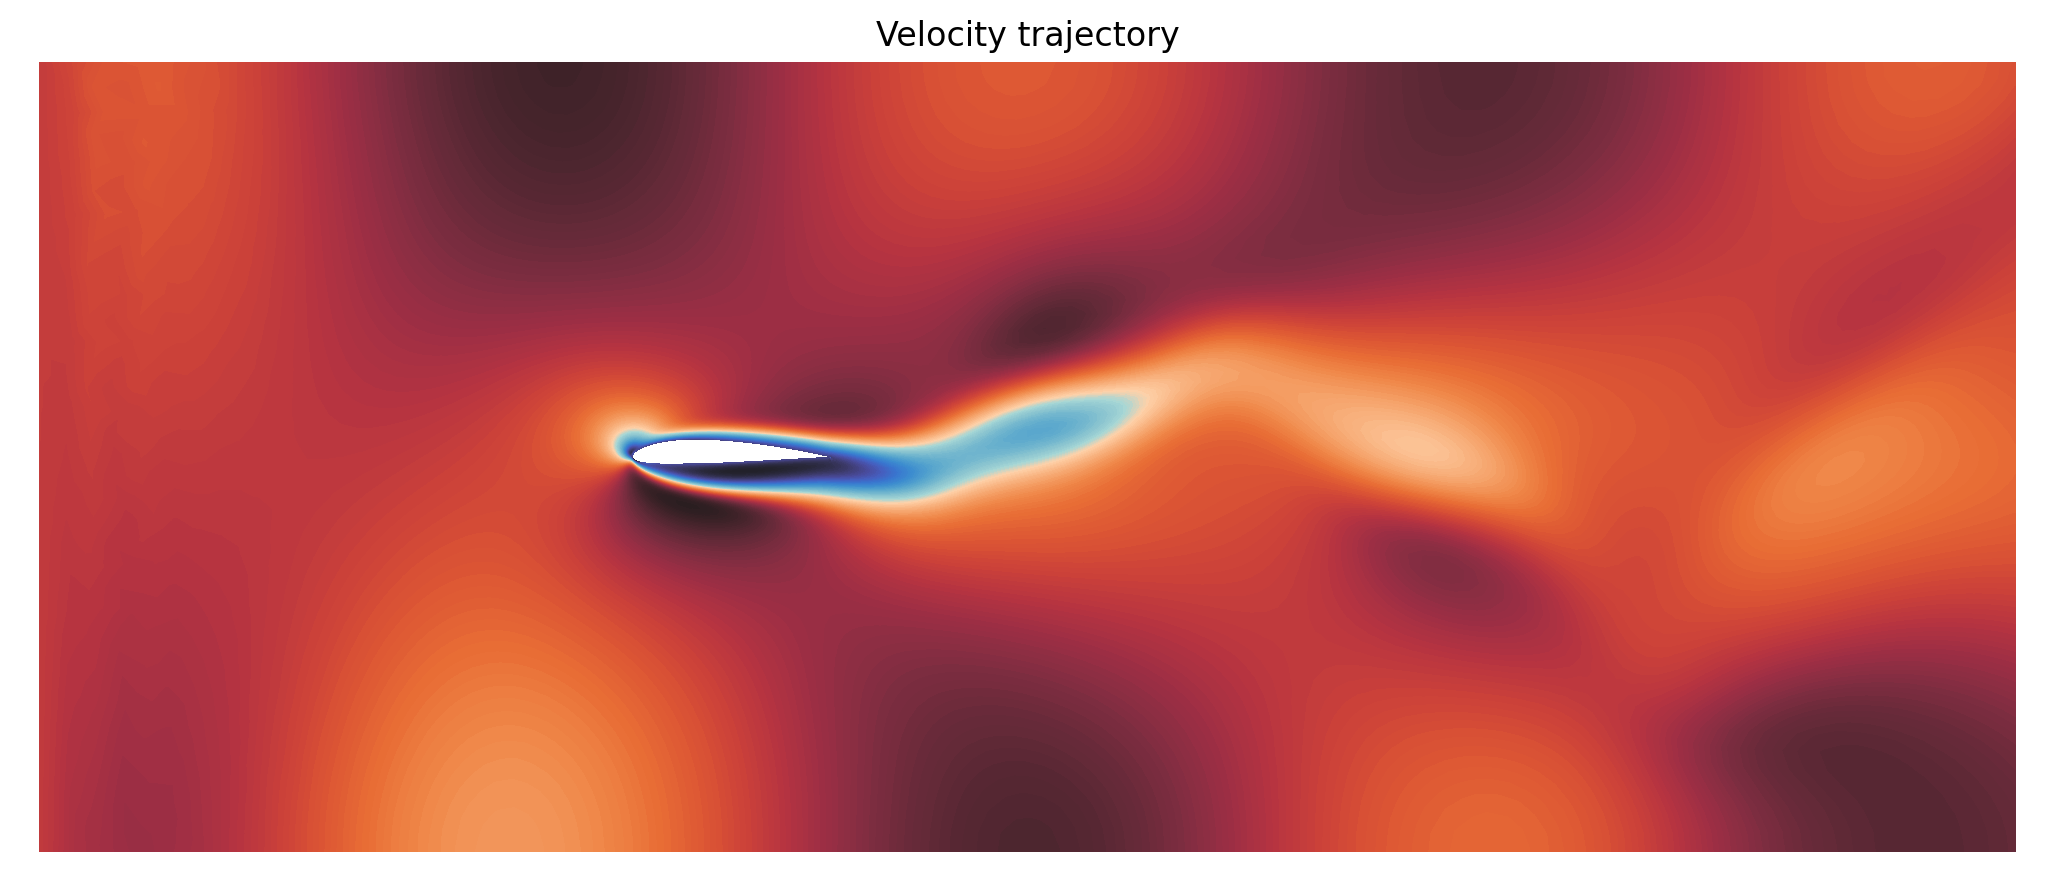

In [42]:
i = 121
data = np.load(f"snapshots/snapshot_{i}.npz")

if "ut" in data:
    u = data["ut"]
    v = data["vt"]
    p = data["pt"]
else:
    u = data["u_np"]
    v = data["v_np"]
    p = data["p_np"]
params = data["params"]
params_geo = params[2:, 0]

def trajectory(vt, params_geo, title = None):
    """
    Trajectory
    Input: trajectory with dimension (ntimes, nvelocity) and geometric parameters
    """
    # redefine plot_v on new triang
    coords, triang = update_coords_and_triang(params_geo)
    def plot_v(v, triang = triang):
        plt.tricontourf(triang, v, cmap = cmap, levels = 200)
        plt.gca().set_aspect("equal")
        add_zoom(zoom = 1.3)

    for i in range(vt.shape[0]):
        plt.figure(figsize=(10,10))
        plot_v(vt[i])
        plt.xlim((-0.1,10.1))
        plt.title(title)
        plt.axis('off')
        display(plt.gcf())
        plt.close()
        clc(wait=True)

# whichtrajectory = 40
whichtimes = np.arange(0, 200, 10)

trajectory(u[whichtimes], params_geo, title = "Velocity trajectory")

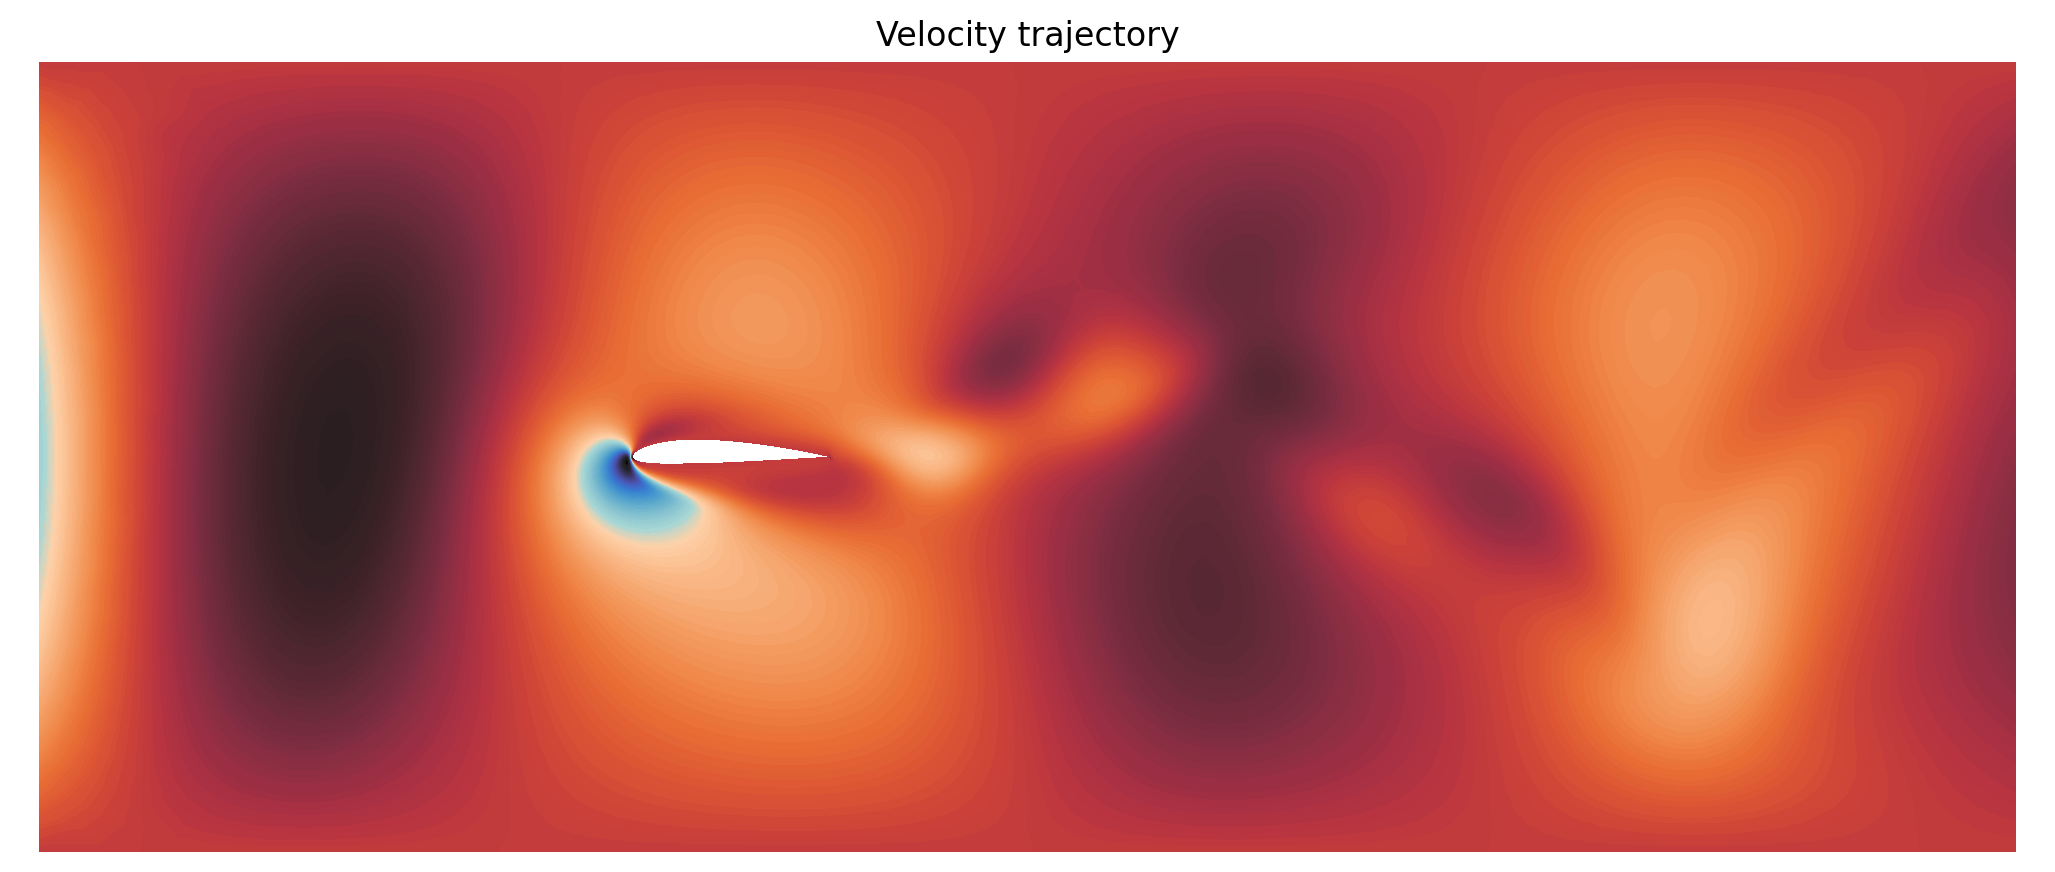

In [45]:
trajectory(v[whichtimes], params_geo, title = "Velocity trajectory")

In [ ]:
trajectory(p[whichtimes], params_geo, title = "Pressure trajectory")